# Analyse de Logs avec Pandas

## Import de librairies

In [1]:
import elasticsearch
from elasticsearch import helpers, TransportError
import pandas as pd

/home/bigdatalover/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


## Analyse de Logs

On se connecte à Elasticsearch pour y récupérer les Logs qui ont été préalablement parsés et structurés via le Notebook <b> Parsing de Logs avec Python </b> ...

In [2]:
ES_CLIENT = elasticsearch.Elasticsearch("localhost:9200", timeout=10000)

In [3]:
len(ES_CLIENT.search(index="logs", size=10000)["hits"]["hits"])

10000

La fonction ci-dessous permet de charger des données depuis Elasticsearch correspondant à un nombre de Logs possiblement supérieur à 10000 (car un simple appel à  <b> search </b> peut au max charger 10000 Logs)

In [4]:
def es_load_long(es_client, index, body=None, size=10000, sort=None):
    """
        Loads more than 10000 entries from  Elasticsearch matching a query
        and using scrolling technique
    """

    try:
        results = es_client.search(
            index=index, scroll="2m", body=body, size=size, sort=sort)
        scroll_id = results["_scroll_id"]
        scroll_size = results["hits"]["total"]
        q_results = results["hits"]["hits"]
        while scroll_size>0:
            results = es_client.scroll(scroll_id=scroll_id, scroll="2m")
            scroll_id = results["_scroll_id"]
            scroll_size = len(results["hits"]["hits"])
            q_results += results["hits"]["hits"]
        return q_results
    except TransportError as transport_error:
        raise transport_error

Voilà le nombre de Logs qui ont été chargés grâce à cette fonction.  Le paramètre <b> "logs" </b> correspond à l'index Elasticsearch (équivalent par e.g. table SQL) où sont stockés les Logs.

In [5]:
len(es_load_long(ES_CLIENT, "logs"))

26311

On charge tous les Logs dans une variable <b> data </b>

In [6]:
data = es_load_long(ES_CLIENT, "logs")

<b> data </b> est une liste de dictionnaires, on la transforme en un <b> Pandas DataFrame </b>

In [7]:
logs_dataframe = pd.DataFrame([item["_source"] for item in data])

La méthode <b> DataFrame.head(n) </b> où <b> n </b> est un paramètre permet d'afficher les <b> n </b> premières lignes d'un objet DataFrame.

In [8]:
logs_dataframe.head(10)

,Date,IP,Request,Status,Url
0,2015-12-01T00:00:00,90.154.66.233,POST,200.0,/administrator/index.php
1,2015-12-01T00:00:00,46.72.213.133,GET,200.0,/administrator/
2,2015-12-01T00:00:00,178.204.119.130,POST,200.0,/administrator/index.php
3,2015-12-01T00:00:00,178.35.0.41,POST,200.0,/administrator/index.php
4,2015-12-01T00:00:00,92.252.165.97,GET,200.0,/administrator/
5,2015-12-01T00:00:00,92.252.165.97,POST,200.0,/administrator/index.php
6,2015-12-01T00:00:00,83.219.151.232,GET,200.0,/administrator/
7,2015-12-01T00:00:00,213.24.134.32,POST,200.0,/administrator/index.php
8,2015-12-01T00:00:00,191.182.199.16,GET,200.0,/
9,2015-12-01T00:00:00,191.182.199.16,GET,200.0,/media/system/js/caption.js


On désire maintenant avoir le compte de chaque type de requête (GET, POST etc) <br>
Voilà le code qui nous permet de le faire, incluant un filtrage par colonne du DataFrame pour garder que la colonne  qui nous intéressé <b> Request </b>; puis un <b> groupby </b> sur cette colonne et l'agrégation qu'on va utiliser à savoir <b> count </b>

In [9]:
requests_types = logs_dataframe[["Request"]].groupby(["Request"])["Request"].count()

On trie maintenant les résultats dans le sens décroissant (du type de requête apparaissant le plus souvent dans les Logs au moins souvent)

In [10]:
requests_types = requests_types.sort_values(ascending=False)

Voilà le compte de chaque type de requête... avec une prépondérance nette du type <b> GET </b> ce qui est normal dans des Logs d'accès...

In [11]:
requests_types

Request
GET     21685
POST     4603
HEAD       16
PUT         6
Head        1
Name: Request, dtype: int64

On voudrait maintenant afficher un camembert avec les pourcentages de présence de chaque type de requête. Pour ce, on fait appel à la librairie graphique <b> matplotlib </b> de Python en conjonction de la librairie <b> pandas </b>

In [12]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

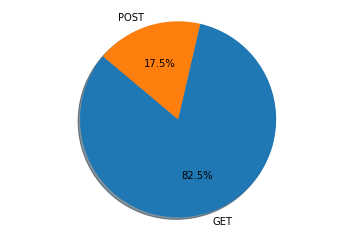

In [13]:
labels = list(requests_types.index[:2])
counts = list(requests_types[:2])
plt.pie(counts, labels=labels,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

On désire maintenant observer ces comptes mois par mois... <br>
On commence par rajouter une colonne <b> counts </b>  avec que des 1 au DataFrame d'origine contenant tous les Logs.

In [14]:
logs_dataframe = pd.concat([logs_dataframe, pd.DataFrame({'counts': [1]*len(logs_dataframe)})], axis=1)

In [15]:
logs_dataframe.head()

,Date,IP,Request,Status,Url,counts
0,2015-12-01T00:00:00,90.154.66.233,POST,200.0,/administrator/index.php,1
1,2015-12-01T00:00:00,46.72.213.133,GET,200.0,/administrator/,1
2,2015-12-01T00:00:00,178.204.119.130,POST,200.0,/administrator/index.php,1
3,2015-12-01T00:00:00,178.35.0.41,POST,200.0,/administrator/index.php,1
4,2015-12-01T00:00:00,92.252.165.97,GET,200.0,/administrator/,1


Comme avant, on filtre les colonnes dont on a besoin dans le DataFrame résultant... puis on effectue cette fois-ci un double <b> groupby </b> en commençant par la colonne <b> Date </b> où on va grouper les Logs mois par mois puis la colonne <b> Request </b> où on va, pour chaque mois, grouper les Logs par type de requête. La fonction d'agrégation est <b> sum </b> qui permet de sommer tous les 1 de la colonne restante à savoir <b> counts </b> pour chaque groupe.

In [16]:
requests_counts = logs_dataframe[["Date", "Request", "counts"]].groupby(["Date", "Request"]).sum()

In [17]:
df = requests_counts.reset_index()

Pour pouvoir afficher un <b> stacked histogram </b> qui permet de visualiser le nombre de chaque type de requête par mois, on utilise tout d'abord la méthode <b> pivot() </b> du DataFrame qui permet de redistribuer les données selon de nouveaux axes pour avoir les dates ou mois en abscisse et les comptes des types de requêtes en ordonnées.

In [18]:
pivot_df = df.pivot(index='Date', columns='Request', values='counts')
pivot_df

Request,GET,HEAD,Head,POST,PUT
Date,,,,,
2015-12-01T00:00:00,10172.0,9.0,1.0,3960.0,6.0
2016-01-01T00:00:00,11513.0,7.0,NaN,643.0,NaN


Ensuite, on utilise la méthode <b> bar() </b> qui a besoin de <b> matplotlib </b> pour fonctionner en lui passant entre autres un paramètre <b> stacked=True </b>

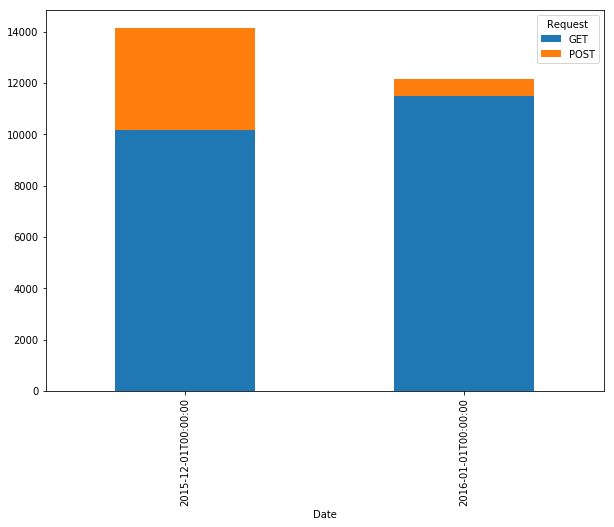

In [19]:
pivot_df.loc[:,['GET','POST']].plot.bar(stacked=True, figsize=(10,7))